In [1]:
from imagegrains import segmentation_helper, data_loader, plotting
from pathlib import Path
import torch
import matplotlib.pyplot as plt

>> Initializing ImageGrains with CellposeSAM:


Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	win32 
python version: 	3.10.18 
torch version:  	2.7.1+cu118! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




## Download pre-trained models and demo data  
This notebook will try to use segementation results from the previous notebook **1_image_segmentation**.

In [2]:
download_path = Path.home().joinpath('imagegrains')
data_path = download_path.joinpath('demo_data','FH').as_posix()

## Check local GPU setup  
If you have a GPU, you can run the following cell to check if it is properly set up. Pleasse make sure to follow the instructions for correct installation in the [README](https://github.com/dmair1989/imagegrains#local-installation) to enable GPU support. If you work on a Mac you can try to install the Cellpose package with experimental M1 support (see [here](https://cellpose.readthedocs.io/en/latest/installation.html#m1-mac-installation)).

In [3]:
# List GPU devices and CUDA version
!nvidia-smi -L 
!nvcc --version
# Check GPU memory
!nvidia-smi -q -d Memory 

print(f"PyTorch version: {torch.__version__}")
print(f"GPU available for pytorch: {torch.cuda.is_available()}")

GPU 0: NVIDIA GeForce RTX 3070 (UUID: GPU-4a37592b-3d89-ef2d-b359-5a4eb10a9466)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0

==============NVSMI LOG==============

Timestamp                                 : Fri Jul 25 14:24:30 2025
Driver Version                            : 560.94
CUDA Version                              : 12.6

Attached GPUs                             : 1
GPU 00000000:01:00.0
    FB Memory Usage
        Total                             : 8192 MiB
        Reserved                          : 174 MiB
        Used                              : 3724 MiB
        Free                              : 4295 MiB
    BAR1 Memory Usage
        Total                             : 256 MiB
        Used                              : 228 MiB
        Free                              : 28 MiB
    Conf 

## Train models based on Cellpose-SAM  via default Cellpose training
Here we train a model for a set of images (usually own data combined with the data from https://zenodo.org/records/8005771). Requirements for the data are:
1) Each image file (ideally in `.jpg` format) needs a label file (with teh same name as the image and `_mask` at the end of the filename; as `.tif` with the exact same extend and resolution as the image file) that holds the ground truth masks (each grain has to have an individual label).
2) The images and masks should be split into a `test` and `train` subfolder. The `data_path` should refer to the parent folder (please use a full path).

In [4]:
# using the demo files
data_path = f'{download_path}/demo_data/FH/' 

# OR path to custom dataset (uncomment next line to use)
#data_path = "E:/David/cellpose/fh/" 

### Find files

In [5]:
train_images,train_masks,test_images,test_masks = data_loader.find_data(data_path)
print('Number of images:',len(train_images),'/',len(test_images))

Number of images: 6 / 1


### (Optional) Ensure correct names

In [6]:
segmentation_helper.check_labels(train_masks);
segmentation_helper.check_labels(test_masks);
segmentation_helper.check_im_label_pairs(train_images,train_masks);
segmentation_helper.check_im_label_pairs(test_images,test_masks);

No files renamed.
No files renamed.
All images have labels.
All images have labels.


### (Optional) Visual data check

Training images/labels


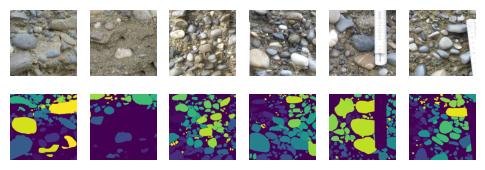

In [7]:
plt.figure(figsize=(len(train_images),2))
plotting.show_training_set(train_images)
print('Training images/labels')

Test images/labels


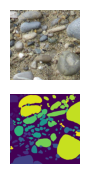

In [8]:
print('Test images/labels')
plt.figure(figsize=(len(test_images),2))
plotting.show_training_set(test_images)

For more options you can use the default training for cellpose (not recommended). Here you can use all of the `CellposeModel.train()` parameters:   
https://cellpose.readthedocs.io/en/latest/api.html#module-cellpose.train

In [10]:
from cellpose import models, io, train

io.logger_setup()

#The Cellpose model needs the images pre-loaded. 
train_data,train_labels,test_data,test_labels = [],[],[],[]
for x1,y1 in zip(train_images,train_masks):
    train_data.append(io.imread(str(x1)))
    train_labels.append(io.imread(str(y1)))

for x2,y2 in zip(test_images,test_masks):
    test_data.append(io.imread(str(x2)))
    test_labels.append(io.imread(str(y2)))

#create model object
model = models.CellposeModel(gpu=True)
masks_ext = "_mask"
model_name = "IG2_cpSAM_new_model"
#train (uncomment next lines to use)
new_model_path, train_losses, test_losses = train.train_seg(model.net,
                                                            n_epochs = 100,
                                                            train_data=train_data,
                                                            train_labels=train_labels,
                                                            test_data=test_data,
                                                            test_labels=test_labels,
                                                            model_name=model_name
                                                            )

2025-07-25 14:26:01,689 [INFO] WRITING LOG OUTPUT TO C:\Users\3DUser\.cellpose\run.log
2025-07-25 14:26:01,689 [INFO] 
cellpose version: 	4.0.6 
platform:       	win32 
python version: 	3.10.18 
torch version:  	2.7.1+cu118
2025-07-25 14:26:01,798 [INFO] ** TORCH CUDA version installed and working. **
2025-07-25 14:26:01,799 [INFO] >>>> using GPU (CUDA)
2025-07-25 14:26:03,302 [INFO] >>>> loading model C:\Users\3DUser\.cellpose\models\cpsam
2025-07-25 14:26:03,819 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.45it/s]

2025-07-25 14:26:05,564 [INFO] computing flows for labels


2025-07-25 14:26:05,815 [INFO] >>> computing diameters


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]

2025-07-25 14:26:05,826 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}
2025-07-25 14:26:05,892 [INFO] >>> n_epochs=15, n_train=6, n_test=1
2025-07-25 14:26:05,892 [INFO] >>> AdamW, learning_rate=0.00005, weight_decay=0.10000
2025-07-25 14:26:05,894 [INFO] >>> saving model to E:\David\notebooks\models\IG2_cpSAM_new_model


2025-07-25 14:26:07,712 [INFO] 0, train_loss=2.4375, test_loss=2.4375, LR=0.000000, time 1.82s
2025-07-25 14:26:14,779 [INFO] 5, train_loss=1.5201, test_loss=1.0938, LR=0.000028, time 8.88s
2025-07-25 14:26:21,846 [INFO] 10, train_loss=0.8788, test_loss=0.8164, LR=0.000050, time 15.95s
2025-07-25 14:26:27,452 [INFO] saving network parameters to E:\David\notebooks\models\IG2_cpSAM_new_model
